In [8]:
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
import numpy as np
import tensorflow as tf
import pprint
from cost_functions import *
from misc_utils import *
#from public_tests import *
%matplotlib inline

Load VGG19 

In [9]:
img_size = 256
vgg = tf.keras.applications.VGG19(include_top=False,
                                  input_shape=(img_size, img_size, 3),
                                  weights='imagenet')

vgg = replace_maxpool_with_avgpool(vgg)
vgg.trainable = False

Chose your style and content layers. Uncomment the top to list all layers

In [10]:
#Chose layers to use when calculating style cost

#for layer in vgg.layers:
#    print(layer.name)

STYLE_LAYERS = [
    ('block1_conv1', 100),#200
    #('block1_conv2', 0.2),
    ('block2_conv1', 20),#20
    #('block2_conv2', 0.2),
    ('block3_conv1', 20),#20
    #('block3_conv2', 0.2),
    #('block3_conv3', 0.2),
    ('block4_conv1', 0.00002),#0.00002
    #('block4_conv2', 0.2),
    #('block4_conv3', 0.2),
    #('block4_conv4', 0.2),
    ('block5_conv1', 2),
    #('block5_conv2', 0.2),
    #('block5_conv3', 0.2),
    #('block5_conv4', 0.2)
    ]

CONTENT_LAYERS = [('block4_conv1', 1)]
'''
CONTENT_LAYERS = [('block3_conv2', 2),
                ('block4_conv1', 1),
                 ('block4_conv2', 1),
                ('block4_conv3', 1),
                ('block4_conv4', 1)]
'''
INPUT_LAYERS = [(vgg.layers[0].name, 1)]

vgg_style_outputs = get_layer_outputs(vgg, STYLE_LAYERS)
vgg_model_content_outputs = get_layer_outputs(vgg, CONTENT_LAYERS)
inputs_layer_output = get_layer_outputs(vgg, INPUT_LAYERS)


In [11]:
content_image, style_image, generated_image = load_images("images/sib.jpg", "images/monet.jpg", "output/image_test_10500.jpg", img_size=img_size)

In [12]:
# Assign the content image to be the input of the VGG model.  
# Set a_C to be the hidden layer activation from the layer we have selected
preprocessed_content =  tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
a_C = vgg_model_content_outputs(preprocessed_content)
# Assign the input of the model to be the "style" image 
preprocessed_style =  tf.Variable(tf.image.convert_image_dtype(style_image, tf.float32))
a_S = vgg_style_outputs(preprocessed_style)

content_target = vgg_style_outputs(content_image)  # Content encoder
style_targets = vgg_style_outputs(style_image)     # Style encoder

In [13]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

#@tf.function()
def train_step(generated_image):
    with tf.GradientTape() as tape:
        # In this function you must use the precomputed encoded images a_S and a_C
        
        ### START CODE HERE
        
        # Compute a_G as the vgg_style_outputs for the current generated image
        #(1 line)
        a_G_s = vgg_style_outputs(generated_image)
        a_G_c = vgg_model_content_outputs(generated_image)
        
        # Getting the original image for denoising
        a_I = inputs_layer_output(generated_image)
        
        # Compute the style cost
        #(1 line)
        J_style = compute_style_cost(a_S, a_G_s, STYLE_LAYERS)
        
        #(2 lines)
        # Compute the content cost
        J_content = compute_content_cost(a_C,a_G_c)
        
        
        #J_noise = compute_noise_cost(a_I)
        J_noise = 0
        
        # Compute the total cost
        J = total_cost(J_content, J_style, J_noise, alpha = 4, beta = 4000, gamma = 0)
        
        ### END CODE HERE
        
    grad = tape.gradient(J, generated_image)

    optimizer.apply_gradients([(grad, generated_image)])
    generated_image.assign(clip_0_1(generated_image))
    #J_style = compute_style_cost(a_S, a_G_s, STYLE_LAYERS, layer_wise_output=True)
    # For grading purposes
    return J, J_style, J_content, J_noise

Epoch 0 with J: 20171.462890625, J_style: 5.009188652038574, J_content: 33.67717742919922, J_noise: 0


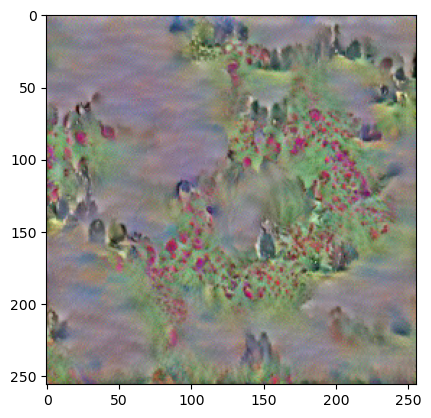

Epoch 25 with J: 8655.19921875, J_style: 2.1286511421203613, J_content: 35.148780822753906, J_noise: 0
Epoch 50 with J: 6613.20556640625, J_style: 1.6179646253585815, J_content: 35.336830139160156, J_noise: 0
Epoch 75 with J: 5528.73779296875, J_style: 1.346836805343628, J_content: 35.347633361816406, J_noise: 0
Epoch 100 with J: 4788.14404296875, J_style: 1.1616623401641846, J_content: 35.373600006103516, J_noise: 0
Epoch 125 with J: 4219.19482421875, J_style: 1.0194038152694702, J_content: 35.39493942260742, J_noise: 0
Epoch 150 with J: 3756.07470703125, J_style: 0.9036020636558533, J_content: 35.41664505004883, J_noise: 0
Epoch 175 with J: 3364.48095703125, J_style: 0.8056883215904236, J_content: 35.43191909790039, J_noise: 0
Epoch 200 with J: 3028.15283203125, J_style: 0.7216039896011353, J_content: 35.43418502807617, J_noise: 0
Epoch 225 with J: 2738.350341796875, J_style: 0.6491680145263672, J_content: 35.41952896118164, J_noise: 0
Epoch 250 with J: 2485.9970703125, J_style: 0.58

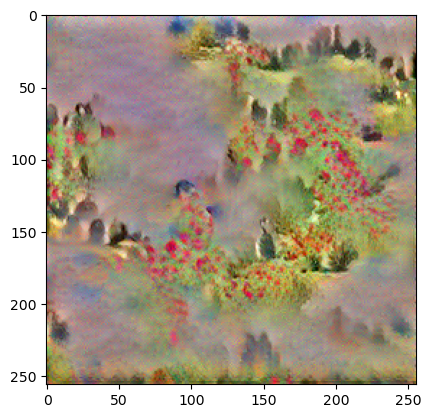

Epoch 525 with J: 1116.0238037109375, J_style: 0.24402466416358948, J_content: 34.981300354003906, J_noise: 0
Epoch 550 with J: 1062.3768310546875, J_style: 0.23066329956054688, J_content: 34.930904388427734, J_noise: 0
Epoch 575 with J: 1014.6324462890625, J_style: 0.2187695950269699, J_content: 34.888526916503906, J_noise: 0
Epoch 600 with J: 972.1575927734375, J_style: 0.2081931084394455, J_content: 34.84627914428711, J_noise: 0
Epoch 625 with J: 934.0435791015625, J_style: 0.19870787858963013, J_content: 34.803001403808594, J_noise: 0
Epoch 650 with J: 899.556640625, J_style: 0.1901274472475052, J_content: 34.761714935302734, J_noise: 0
Epoch 675 with J: 868.1356811523438, J_style: 0.18231093883514404, J_content: 34.72297668457031, J_noise: 0
Epoch 700 with J: 839.4910278320312, J_style: 0.17518898844718933, J_content: 34.68376541137695, J_noise: 0
Epoch 725 with J: 813.4236450195312, J_style: 0.1687108278274536, J_content: 34.64508056640625, J_noise: 0
Epoch 750 with J: 789.645263

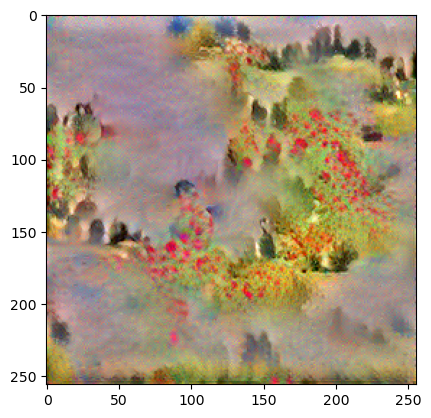

Epoch 1025 with J: 614.2006225585938, J_style: 0.1193225234746933, J_content: 34.22762680053711, J_noise: 0
Epoch 1050 with J: 603.0626220703125, J_style: 0.11657294631004333, J_content: 34.192718505859375, J_noise: 0


KeyboardInterrupt: 

In [14]:
# Show the generated image at some epochs
# Uncomment to reset the style transfer process. You will need to compile the train_step function again 
epochs = 40000
for i in range(epochs):
    J, J_style, J_content, J_noise = train_step(generated_image)
    if i % 25 == 0:
        print(f"Epoch {i} with J: {J}, J_style: {J_style}, J_content: {J_content}, J_noise: {J_noise}")
        #for i, layer_cost in enumerate(J_style):
            #print(f"Layer {STYLE_LAYERS[i]} cost: {layer_cost}")
    if i % 500 == 0:
        image = tensor_to_image(generated_image)
        imshow(image)
        image.save(f"output/image_test_{i}.jpg")
        plt.show() 

In [ ]:
a_G_s = vgg_style_outputs(generated_image)
J_style = compute_style_cost(a_S, a_G_s, STYLE_LAYERS, layer_wise_output=True)
for i, layer_cost in enumerate(J_style):
   print(f"Layer {STYLE_LAYERS[i]} cost: {layer_cost}")

print(tf.nn.softmax(J_style))

Layer ('block1_conv1', 0.2) cost: 0.0003244384133722633
Layer ('block2_conv1', 0.2) cost: 0.005392922088503838
Layer ('block3_conv1', 0.2) cost: 0.00252921343781054
Layer ('block4_conv1', 0.2) cost: 0.008417122066020966
Layer ('block5_conv1', 0.2) cost: 0.0007616213988512754
tf.Tensor([0.19936794 0.20038101 0.199808   0.20098792 0.19945513], shape=(5,), dtype=float32)


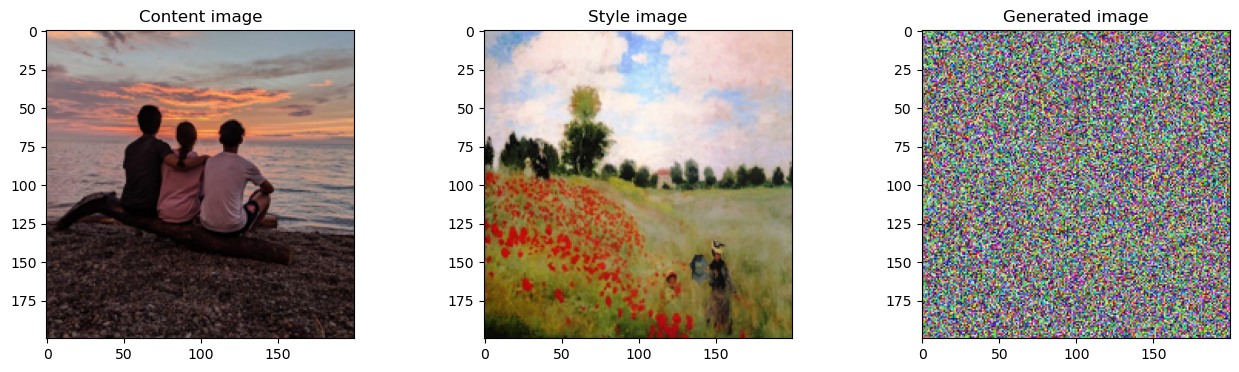

In [ ]:
# Show the 3 images in a row
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
imshow(content_image[0])
ax.title.set_text('Content image')
ax = fig.add_subplot(1, 3, 2)
imshow(style_image[0])
ax.title.set_text('Style image')
ax = fig.add_subplot(1, 3, 3)
imshow(generated_image[0])
ax.title.set_text('Generated image')
plt.show()